# Assignment 1: Time-series data

**This assignment consists of five parts:**

1. Create synthetic data to test the algorithm you design.
2. Write two functions:
    - autocorrelation.
    - period extraction function.
3. Use a periodogram function.
4. Compare the sensitivity of the algorithms to typical imperfections occur in real data (noise, missing data, random and non-periodic patterns).
5. Test the algorithms on geolife data.
 


Part 1-3 will make up **60% of your grade**, part 4 and 5 constitute **40% of your grade**.

**WARNING: Make sure to read through the entire assignment before starting to code. The tasks build on each other!**

Good luck with the assignment! Deadline is **October 11th, at 23:55** hrs. Please push your code to the GitHub classroom before the deadline. **Make sure to read the *"Submission procedure"* section in the *"README.md"* file to ensure reproducibility.**


## 0th part: Prerequisites 
Please add any packages you use to the code cell below.

In [15]:
from typing import List, Any, Union
from pandas import read_csv
from pandas.plotting import autocorrelation_plot
from math import sin, cos, sqrt, atan2, radians,asin
import skmob
from scipy.signal import lombscargle
from datetime import timezone
import time
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot
from bokeh.io import output_notebook, output_file
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models.tools import HoverTool
from datetime import datetime, timedelta
from bokeh.tile_providers import CARTODBPOSITRON, STAMEN_TERRAIN
from bokeh.themes import built_in_themes
from bokeh.io import curdoc
from sympy import fft
import os



## 1st part: Create Synthetic Data

Imagine that you have a GPS device that takes a measurement every 10 minutes. Create a synthetic data trajectory with two periodicities for 365 days. The trajectory data should include two types of periodicities (e.g., one daily and one weekly). For example, you can take your home-Snellius trajectory as a daily trajectory repeating from Monday to Friday (daily period) and your weekly trip to the supermarket or city center from home during the weekend as the second one (weekly period). Assume that you have a regular schedule (e.g. leaving every day at 8 and returning at 5). Simulate the whole trajectory (the path and the time you spend in each place). You can find GPS locations via Google Maps (right-click on map - what is here?) or any other online map service. Try to think of scenarios that make this data as accurate as possible. You can be creative about your home location because that's private information!

The GPS location of the entrance of the Snellius building is: 52.169709, 4.457111. 

Use a constant time between waypoints / GPS locations for this exercise.

Tip I : a periodicity of 24 is a recurring event every 24 hrs (i.e. a daily event), a periodicity of 168 hrs is a weekly event. The final time series should have a dimension of 144 (24hrs*60mins/10mins) * 365. 

Tip II: We talked so far about processing one time series. In case two time-series acquired from two coordinates is difficult to handle, try to use only one, or combine them into one value (e.g. lat^2 + long^2).

Tip III: Stuck with how to simulate data? Check the Lab of the first week and get some inspiration there. You are free to simulate coordinates per minute or hour. Take a decision and go with it. You can always go back to your simulation later and make it more realistic. 



In [16]:
SneliusCoord=[4.457111, 52.169709]
SupermaketCoord=[4.474798, 52.172679]
HomeCoord=[4.475071, 52.169961]
CityCenterLeiden=[4.4870, 52.1665]

def totimestamp(dt, epoch=datetime(1970,1,1)):
    td = dt - epoch
    # return td.total_seconds()
    return (td.microseconds + (td.seconds + td.days * 24 * 60) / 10) * 365
def simulate(home_coord, supermarket_coord, snellius_coord):
    import openrouteservice as opn
    from openrouteservice.directions import directions
    from openrouteservice import convert
    import numpy as np
    import folium
    from branca.element import Figure

    api_key = "5b3ce3597851110001cf6248511de185465740819530ac78c23e3fc5" 
    clnt = opn.Client(key=api_key)

    # decode_polyline needs the geometry only (see above)
    params_iso = {
        "profile": "foot-walking",#"cycling-road",
        "intervals": [1200],  # 120/60 = 2 mins
        "segments": 120,
        "attributes": ["total_pop"],  # Get population count for isochrones
    }

    # simulate data in form of two timeseries latitude and longitude of length (144*365):
    # Some coordinates

    m = folium.Map(location=snellius_coord, tiles='cartodbpositron', zoom_start=13)
    coordinates = [snellius_coord,supermarket_coord,home_coord,snellius_coord]
    coordinatesweekend= [[4.4870, 52.1665],[4.474798, 52.172679],[4.475071, 52.169961],[4.4870, 52.1665]]

    # The popup will show the ID in the coordinate list. In a non-optimized waypoint order, the waypoints
    # would have been visited from ID 0 to ID 3 sequentially.
    coords_rd=[]
    for idx, coords in enumerate(coordinates):
        coords_rd.append(coords)
        folium.Marker(location=list(reversed(coords)),
                     popup=folium.Popup("ID: {}".format(idx))).add_to(m)

    route = clnt.directions(
        coordinates=coordinates,
        profile='foot-walking',
        format='geojson',
        validate=False,
        optimize_waypoints=True
    )

    routeweekend=clnt.directions(
        coordinates=coordinatesweekend,
        profile='foot-walking',
        format='geojson',
        validate=False,
        optimize_waypoints=True
    )
    folium.PolyLine(locations=[list(reversed(coord)) 
                               for coord in
                               route['features'][0]['geometry']['coordinates']]).add_to(m)
    #print(route)

    locations=[list(reversed(coord)) for coord in route['features'][0]['geometry']['coordinates']]
    locationsw=[list(reversed(coord)) for coord in routeweekend['features'][0]['geometry']['coordinates']]
    print(len(locationsw))
    print("number of locations:{}".format(len(locations)))
    # Create a map icon
    icon = folium.Icon(
        color="lightgray",
        icon_color="#cc0000",
        prefix="fa",
    )
    #reversed_coords=[4.467926, 52.170207]
    #marker = folium.map.Marker(list(reversed(reversed_coords)), icon=icon, popup='riding school rest of the day')
    #marker.add_to(m)

    #m
    #m.save('snelliusmarkethome.html')

    from datetime import datetime, timedelta

    def datetime_range(start, end, delta):
        current = start
        while current < end:
            yield current
            current += delta

    days=31
    #print("Number of timestamps {}".format(len(dts)))
    trajectories=[]
    for j in range(1,13):
        if j%2==0:
            days=30
        if j==2:
            days=28
        for i in range(0,days):
            #print(i,j)
            dts = [dt.strftime('%Y-%m-%d %H:%M') for dt in 
               datetime_range(datetime(2021, j, i+1, 8), datetime(2021, j, i+1, 17), 
               timedelta(minutes=5.6))]
            for location in range(0,len(locations)):
                trajectories.append([locations[location][0],locations[location][1],dts[location]])
            if i==5 or i==6 or i==12 or i==13 or i==19 or i==20 or i==26 or i==27:
                dtsw = [dt.strftime('%Y-%m-%d %H:%M') for dt in 
                   datetime_range(datetime(2021, j, i+1, 8), datetime(2021, j, i+1, 17), 
                   timedelta(minutes=3))]
                for location in range(0,len(locationsw)):
                    trajectories.append([locationsw[location][0],locationsw[location][1],dtsw[location]])
    simulatedData = skmob.TrajDataFrame(trajectories, latitude=0, longitude=1, datetime=2)
    # print a portion of the TrajDataFrame
    simulatedData.sort_values(by=['datetime'], inplace=True, ascending=False)
    print(simulatedData.head())
    timestamp = []
    for i in simulatedData['datetime']:
        timestamp.append(totimestamp(i))
    df = pd.DataFrame(timestamp)
    simulatedData['datetime1']=df
    simulatedData['latlon']=simulatedData['lat']**2+simulatedData['lng']**2
    simulated_data=simulatedData
    return simulated_data
data_simulation=simulate(SneliusCoord,SupermaketCoord,HomeCoord)
print(data_simulation.head())

140
number of locations:96
             lat       lng            datetime
47711  52.169854  4.475117 2021-12-30 16:52:00
47710  52.169547  4.473210 2021-12-30 16:46:00
47709  52.169501  4.472474 2021-12-30 16:40:00
47708  52.169514  4.471353 2021-12-30 16:35:00
47707  52.169412  4.471349 2021-12-30 16:29:00
             lat       lng            datetime    datetime1       latlon
47711  52.169854  4.475117 2021-12-30 16:52:00  980138880.0  2741.720339
47710  52.169547  4.473210 2021-12-30 16:46:00  980149830.0  2741.671242
47709  52.169501  4.472474 2021-12-30 16:40:00  980162970.0  2741.659858
47708  52.169514  4.471353 2021-12-30 16:35:00  980173920.0  2741.651189
47707  52.169412  4.471349 2021-12-30 16:29:00  980187060.0  2741.640510


## 2nd part: Write two functions

Your task is to write:

 1. A function that performs an [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) on the synthetic data and returns the correlation value and corresponding delay for every possible delay.
 2. A visualisation of the autocorrelation function that shows the correlation value as a function of the delay.
 3. A function that evaluates the output of the autocorrelation function and manages to extract the two simulated periodicities as output. 
 
 Construct the second function such that it will return two numbers as periodic components (24, 168) and indicate which periodicity is more prominent. While implementing the autocorrelaton function, you can try to implement a circular (shifting values from the end of time-series to its begining) or a non-circular version (removing values from the end of time-series). If the your function takes too much time to run, make sure to use the tips on code efficiency from the first lab.



In [17]:
# write your own ACF
autocorr_coef=[]
def autocorrelation(data):
    autocorr=[]
    gamma=np.array(data)
    kvs=np.arange(2,len(gamma)-2)
    for k in kvs:
        mg=np.mean(gamma)
        mgv=mg*np.ones(len(gamma))
        st = (gamma- mgv)**2
        sZero=np.sum(st)/len(gamma)
        mgv=mg*np.ones(len(gamma)-k)
        tt = gamma[:-k]- mgv
        tu=gamma[k:]-mgv
        sK=np.sum(tu*tt)/len(gamma)
        autocor=sK/sZero
        autocorr.append(autocor)
    return autocorr
autocorr_coef.append(autocorrelation(data_simulation['latlon']))
print(autocorr_coef[0])


[0.726786489436492, 0.9075214653508162, 0.6660992984319278, 0.7224497920335822, 0.8349860384887924, 0.6097102608252165, 0.6975676141116958, 0.7360397328833548, 0.536853006972682, 0.657984071610435, 0.6090452282290578, 0.4555771544821785, 0.5997202175447505, 0.47791762606460625, 0.37256024888299916, 0.5116098433341458, 0.35523215721772844, 0.2815420574486583, 0.4157600218697196, 0.2307670126966695, 0.19533519324715076, 0.3031082968144241, 0.12165640469515797, 0.11638993998383196, 0.1786773248932478, 0.028400120490893705, 0.04011579524473171, 0.0695883058965697, -0.058813214745067045, -0.02753450053770617, -0.04039019337724704, -0.13112378557025683, -0.09164857781889475, -0.13182359461379262, -0.1902953901426077, -0.156285820198244, -0.2015672226048516, -0.24398931967322485, -0.2135713588057859, -0.2574391787606158, -0.2864201671340333, -0.2612555249120526, -0.2991785515733861, -0.31491081261521564, -0.3061364163664756, -0.3216625809176257, -0.340432964276798, -0.33433922721614645, -0.33

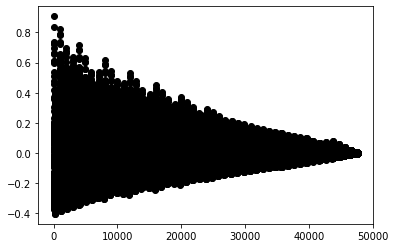

In [18]:
# display ACF on y-axis, time on x-axis

import matplotlib.pyplot as plt

x = np.arange(0,len(autocorr_coef[0]))
y = np.array(autocorr_coef[0])
plt.plot(x, y, 'o', color='black');



[168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 24, 24, 168, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 168, 168, 24, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 24, 168, 168, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 24,

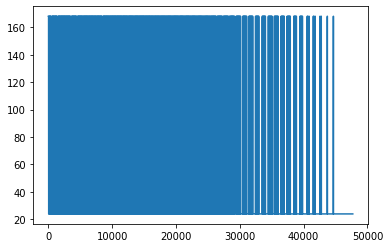

In [19]:
# write your evaluation function
def autocorr_periodicity(simulated_data):

    autocorr = autocorrelation(simulated_data)
    #
    #  finding periods out of autocorrelation by automatically identifying the most dominant peaks
    #
    autocorr_periods=[]
    for v in range(len(autocorr)):
        #print(autocorr[v])
        if autocorr[v] < 0.05:
            x=24
        else:
            x=168
        autocorr_periods.append(x)
    return autocorr_periods
autocorr_period=autocorr_periodicity(data_simulation['latlon'])
print(autocorr_period)
x=np.arange(0,len(autocorr_period))
plt.plot(autocorr_period)

## 3rd part: Periodograms
Take an existing periodogram function from a python packaged (for example Scipy) and run it on the simulated data. Does your evaluation function from the 2nd part works on the results of the periodogram? If not design another algorithm for extracting periods from the periodogram.

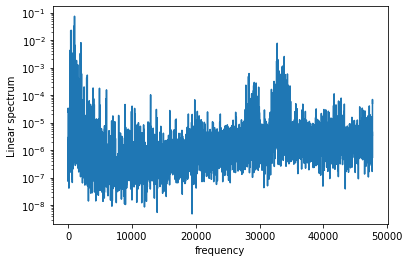

In [20]:
# work with periodogram, find a function available in one of the python packages
from scipy import signal
import matplotlib.pyplot as plt
f , Pxx_spec = signal.periodogram(autocorr_coef[0], len(autocorr_coef[0])*2, 'flattop', scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('frequency')
plt.ylabel('Linear spectrum')
plt.show()

[ 9.58095535  9.58185637  9.58275748 ... 62.8200369  62.82594471
 62.83185307]


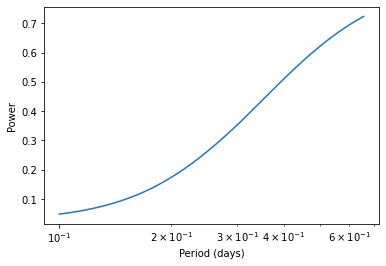

In [21]:
# some help functions
# angular frequency to period
def freq2Period(w):
    return 2 * math.pi / w
# period to angular frequency
def period2Freq(T):
    return 2 * math.pi / T
# write your own periodogram function if needed
def periodogram(x,y,steps=10000, minPeriod=None, maxPeriod=None):
    if not minPeriod:
        minPeriod = 0.1 # for now, let's ignore very short periodic objects
    if not maxPeriod:
        maxPeriod = (np.max(x) - np.min(x))/2 # you cannot detect P > half of your observation period

    maxFreq = np.log2(period2Freq(minPeriod))
    minFreq = np.log2(period2Freq(maxPeriod))
    f = np.power(2, np.linspace(minFreq,maxFreq, steps))
    p = lombscargle(x,y,f,normalize=True)
    return f,p

f,p=periodogram(autocorr_coef[0], np.arange(0,len(autocorr_coef[0]))*2,steps=20000)
print(f)
plt.semilogx(freq2Period(f),p)
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()

In [22]:
# evaluate results of periodogram, write your evaluation function
def periodogram_periodicity(simulated_data):
    # call the periodogram
    #
    f,p=periodogram(simulated_data, np.arange(0,len(simulated_data))*2,steps=20000)
    # find periods from periodogram by automatically identifying the most dominant peaks
    #
    F=f
    P=p
    x=simulated_data
    y=np.arange(0,len(simulated_data))*2
    def findBestPeaks(x, y, F, P, threshold=0.3, n=5):
        # find peaks above threshold
        indexes = np.where(P>threshold)[0]
        # if nothing found, look at the highest peaks anyway
        if len(indexes) == 0:
            q = np.quantile(P, 0.9995)
            indexes = np.where(P>q)[0]
        peaks = []
        start = 0
        end = 0
        for i in indexes:
            if i - end > 10:
                peaks.append((start, end))
                start = i
                end = i
            else:
                end = i
        peaks.append((start, end))
        # increase accuracy on the found peaks
        results = []
        for start, end in peaks:
            if end > 0:
                minPeriod = freq2Period(F[min(F.shape[0]-1, end+1)])
                maxPeriod = freq2Period(F[max(start-1, 0)])
                steps = int(100 * np.sqrt(end-start+1)) # the bigger the peak width, the more steps we want - but sensible (linear increase leads to long computation)
                f, p = periodogram(x, y, steps = steps, minPeriod=minPeriod, maxPeriod=maxPeriod)
                results.append(np.array([freq2Period(f[np.argmax(p)]), np.max(p)]))

        # sort by normalized periodogram score and return first n results
        if results:
            results = np.array(results)
            results = results[np.flip(results[:,1].argsort())]
        else:
            results = np.array([freq2Period(F[np.argmax(P)]), np.max(P)]).reshape(1,2)
        return results[0:n]
    pp=findBestPeaks(x,y,F,P)
    return pp

periodogram_period=periodogram_periodicity(autocorr_coef[0])
print(periodogram_period)

[[0.65579946 0.72324031]]


It might be difficult to find all the correct dominant peaks so we will be lenient in grading if we can see that the code is correct.

## 4th part: Performance

Noise in the data can have different causes:

- Missing measurements at different proportions (randomly or in bursts).
- Noise around the location data. Let's assume your GPS sensor has an approximate range of 50 meters, and noisy points (being 100s of meters away) occur occasionaly due to the cloud cover or the multipath affect of the GPS signal.
- Noise around the temporal data. For example, you assume that you leave home everyday at 8 and return at 5, but you might actually leave a bit earlier or a bit later.
- Irregular behavior by skipping or adding a trajectory. For example, going to school on a saturday or skipping groceries for a week. You can also define a number of new places and paths and add them to the trajectory randomly (e.g. going to the cinema every month with some probability)

Choose at least two noise sources, add them to your simulated data and compare the performance of your ACF and periodogram function. Parametrize your process of injecting these noises according to a rate and check how sensitive your algorithms are to different proportions of these sources of imperfections. Which one performs best? Under what circumstances?



In [23]:
# rate has a value in [0,1] and is used as parameter to define the level of noise added
def add_noise_one(data, rate):
    import numpy as np
    data = np.array(data)
    noise = np.random.normal(0, rate, data.shape)
    noisy_data = data + noise
    return noisy_data


In [24]:
def add_noise_two(data, rate):
    import numpy as np
    data = np.array(data)
    noise = np.random.normal(rate, 1, data.shape)
    noisy_data = data + noise
    return noisy_data


[[2.10052046 0.15251431]]
Those data are noisy 2
[[4.41034144 0.18933506]]
Mean Autocorrelation: -0.000561593430130111
Standard Deviation: 0.5103878929142036
Mean Autocorrelation: 0.4909278744611527
Standard Deviation: 1.0092412183373962


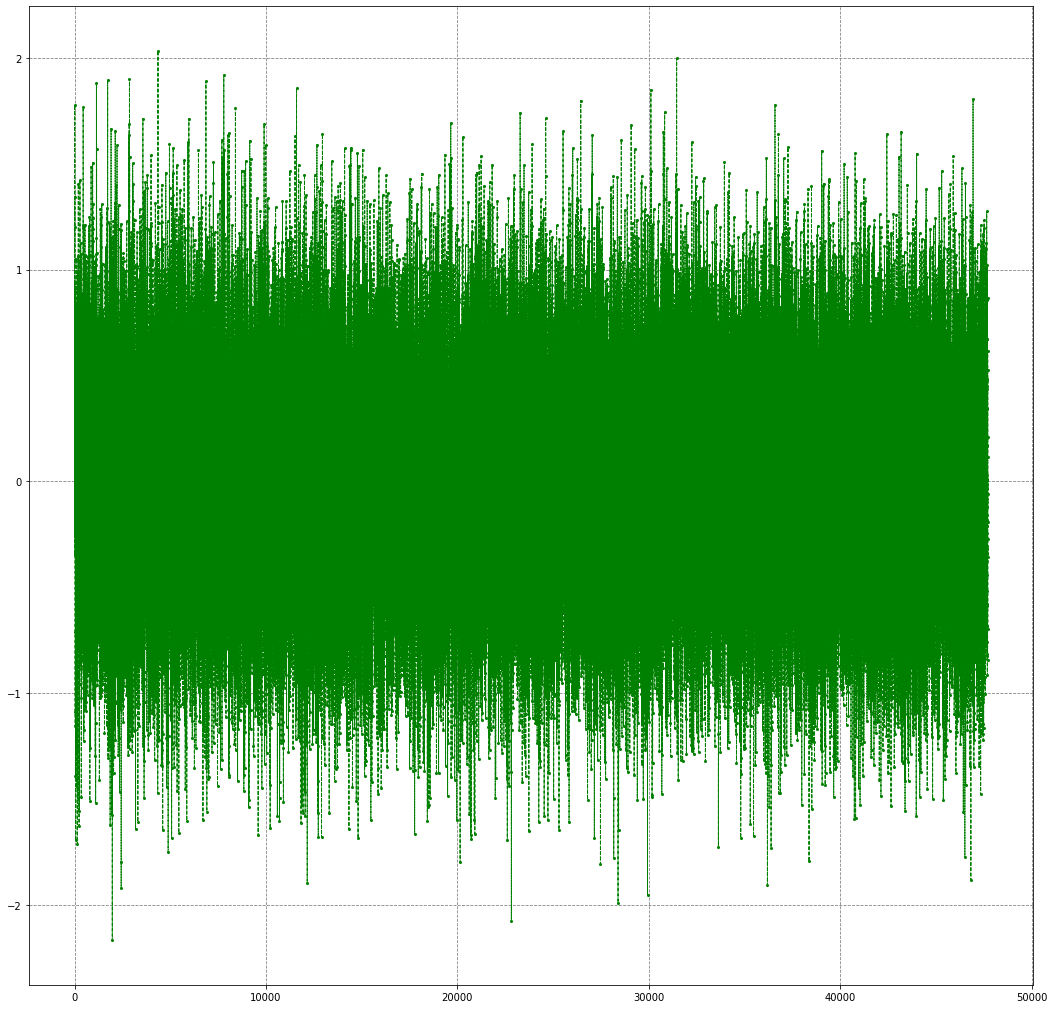

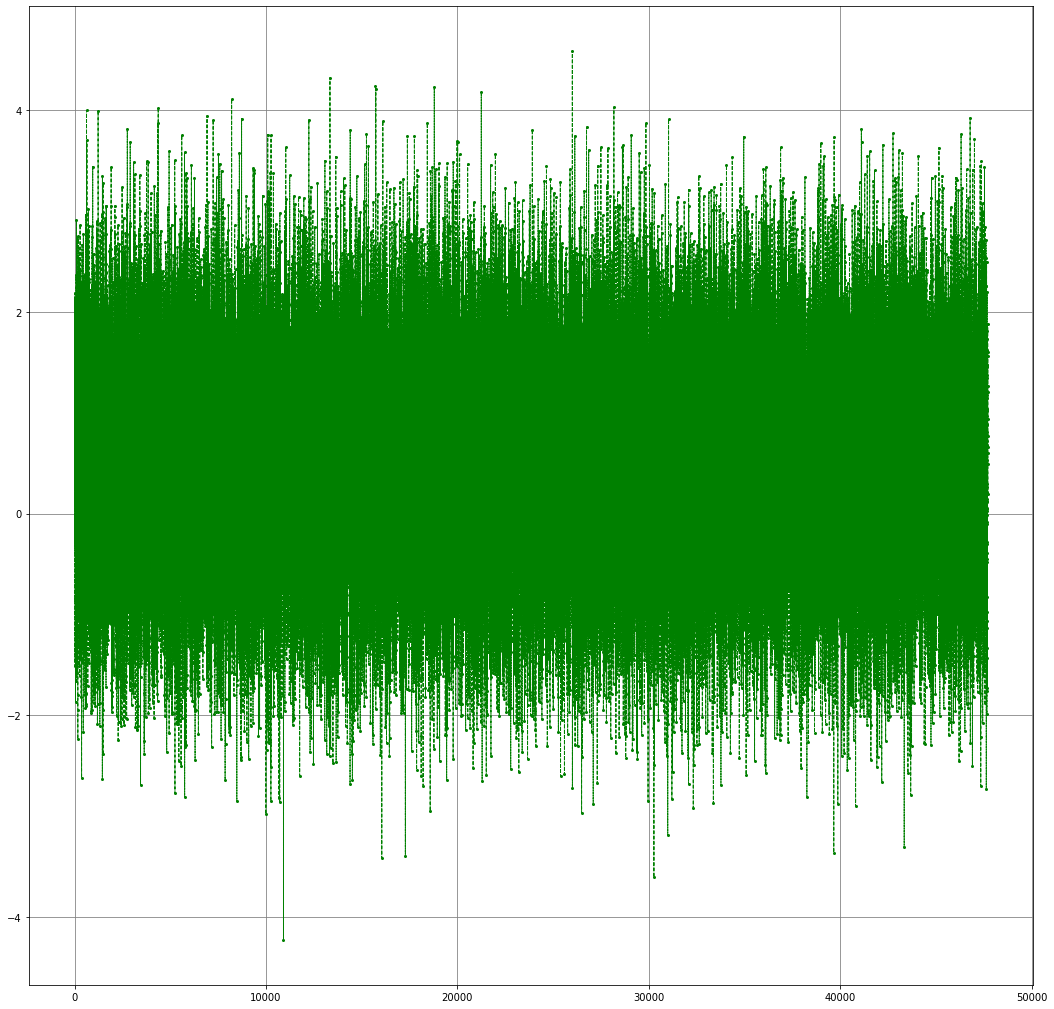

In [30]:
# compare performance
noisy_data1 = add_noise_one(autocorr_coef[0], 0.5)
noisy_data2 = add_noise_two(autocorr_coef[0], 0.5)

autocorr_periodnoisy_data1=autocorr_periodicity(noisy_data1)
#print(autocorr_periodnoisy_data1)
periodogram_periodnoisy_data1=periodogram_periodicity(noisy_data1)
print(periodogram_periodnoisy_data1)
print('Those data are noisy 2')
autocorr_periodnoisy_data2=autocorr_periodicity(noisy_data2)
#print(autocorr_periodnoisy_data2)
periodogram_periodnoisy_data2=periodogram_periodicity(noisy_data2)
print(periodogram_periodnoisy_data2)



def signal_plot(datan,datanw):
    meanautocorr = np.mean(datan)
    stdautocorr = np.std(datan)
    print('Mean Autocorrelation: {}'.format(meanautocorr))
    print('Standard Deviation: {}'.format(stdautocorr))
    meanautocorr = np.mean(datanw)
    stdautocorr = np.std(datanw)
    print('Mean Autocorrelation: {}'.format(meanautocorr))
    print('Standard Deviation: {}'.format(stdautocorr))
    x=np.arange(0,len(datan))
    y=datan
    plt.plot(x, y, 'go--', linewidth=1, markersize=2)
    plt.grid(True,which="both",ls="--",c='gray')  
    plt.gcf().set_size_inches((18, 18)) 
    plt.show(block=True);
    x=np.arange(0,len(datanw))
    y=datanw
    plt.plot(x, y, 'go--', linewidth=1, markersize=2)
    plt.grid(True,which="both",ls="-",c='gray')  
    plt.gcf().set_size_inches((18, 18)) 
    plt.show(block=True);

signal_plot(noisy_data1,noisy_data2)
#signal_plot(autocorr_periodnoisy_data1,periodogram_periodnoisy_data1)
#signal_plot(autocorr_periodnoisy_data2,periodogram_periodnoisy_data2)


### Conclusion
Write a brief report on your findings (150 words max):

The autocorrelation function shows that most of the lags are near to zero. Also, a big portion of lags reach the point of zero point eight, which means that they are not correlated to row 12.\\
The periodicity of autocorrelation displays the distance between the peaks of each center. The periodicity displays a spatial pattern row 13.\\

The periodogram explains the strength of the frequencies in a time series. In row 14 displays the signal frequencies that are positive and displays the pattern of the trajectory.

In row 28 it displays the periodicity outcome of the autocorrelation and the periodogram with noise; the result is is total different from the real data. The most important outcome is that the highest peak of the data has changed from 0.65579946 0.72324031 to 2.37677247 0.24474788 for noisy data 1 and 4.20968583 0.15805642 for noisy data 2.

The autocorrelation function is totally different from the initial one row 20. The noisy data 1 does not match with the sythentic data and almost all of the lags are clustered around(2,-2). The noisy data 2 have almost the same pattern as noisy data 1, with a lag twice higher than noisy data 1. Evidently, the noisy destroys the pattern of the initial signal.


## 5th part: Real life data

You will use data from the geolife datasets to test the time-series analysis methods that you developed. Your task is to apply the methods you just learned and interpret the data. 

[Download the data here](https://www.microsoft.com/en-us/download/details.aspx?id=52367). Select a participant and find out as much as you can about that participant. The participants differ a lot in terms of the number of collected trajectories, you can check several participants.

[The user guide of the entire dataset can be found here](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/User20Guide-1.2.pdf).

Use these questions as a guideline for your analysis: 
- Where was the data gathered? Can you find frequently visited locations by exploring the data?
- What is the general structure of the data? How much noise do you expect? What is the temporal granularity of your data? How long did your participant log their movement?
- Can you find periodic behaviors? What are the periodicities?
- If you cannot identify periodic behaviors: Can you explore why? What makes your data challenging? What realistic aspect of data is missing in your simulation? Having these challenges in mind what would be your topmost priorities, if you were to design a data collection protocol?



In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv

path=os.walk('Data')
dir_list = [directory for directory in path]
#20-21
GPSdata = []
files = []
labels = []
totaldocuments=0
for folder in dir_list[0][1][20:21]:
    for filename in os.walk('Data/'+folder+'/Trajectory/'):
        print(folder,len(filename[2]))
        totaldocuments+= len(filename[2])
        #foldlabel=open('GeolifeT/Data/'+folder+'/labels.txt').read()
        for file in range(0,len(filename[2])):
            with open('Data/'+folder+'/Trajectory/'+str(filename[2][file]), 'r') as f2:
                data = f2.read()[90:-1]
                datalines = data.splitlines()
                for line in datalines:
                    myreader = csv.reader(line.splitlines())
                    for row in myreader:
                        lst=[row[0],row[1],row[2],row[3],row[4],row[5],row[6]]
                        GPSdata.append(lst)
            df = pd.DataFrame(GPSdata)
            df.columns=['Latitude','Longitude','DatasetSetted','Altitude','Days','Date','Time']
    #frame = pd.concat(GPSdata, axis=0, ignore_index=True)
    frame = df.dropna()
print(frame)

020 151
                Latitude         Longitude DatasetSetted Altitude  \
0       39.9744533333333  116.302163333333             0        0   
1               39.97445        116.302165             0        0   
2       39.9746016666667  116.302073333333             0        0   
3               39.97473  116.302066666667             0        0   
4       39.9748116666667         116.30207             0        0   
...                  ...               ...           ...      ...   
177676  39.9772666666667         116.30481             0        0   
177677  39.9772666666667  116.304813333333             0        0   
177678         39.977265        116.304815             0        0   
177679         39.977265  116.304818333333             0        0   
177680  39.9772633333333  116.304821666667             0        0   

                    Days        Date      Time  
0       40780.6100115741  2011-08-25  14:38:25  
1       40780.6100231481  2011-08-25  14:38:26  
2       40780.61

BBox: ('116.302006666667', '116.302428333333', '39.97445', '39.9750616666667')
39.974845           10
39.9749083333333     9
39.9748433333333     8
39.9749              8
39.9749033333333     6
39.97492             5
39.9747166666667     5
39.9748383333333     5
39.97486             5
39.9748466666667     4
39.9748566666667     4
39.9747216666667     4
39.97472             4
39.97484             3
39.9749016666667     3
39.9749183333333     3
39.9748483333333     3
39.974855            3
39.97491             3
39.974715            2
39.9747283333333     2
39.9747183333333     2
39.9748516666667     2
39.974725            2
39.9747              2
Name: Latitude, dtype: int64
Longitude         Latitude        
116.302006666667  39.97484            1
                  39.9748416666667    1
116.302008333333  39.9748433333333    2
                  39.974845           3
                  39.9748466666667    2
                                     ..
116.302426666667  39.97472            1
  

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

/home/Optimus/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 28023 (\N{CJK UNIFIED IDEOGRAPH-6D77}) missing from current font.
  func(*args, **kwargs)
/home/Optimus/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 28096 (\N{CJK UNIFIED IDEOGRAPH-6DC0}) missing from current font.
  func(*args, **kwargs)
/home/Optimus/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from current font.
  func(*args, **kwargs)
/home/Optimus/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 36335 (\N{CJK UNIFIED IDEOGRAPH-8DEF}) missing from current font.
  func(*args, **kwargs)


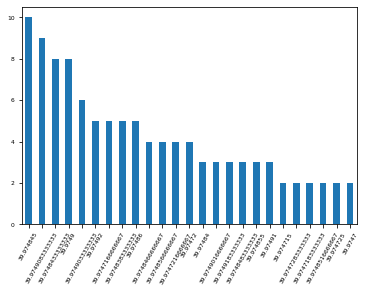

/home/Optimus/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 28023 (\N{CJK UNIFIED IDEOGRAPH-6D77}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/Optimus/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 28096 (\N{CJK UNIFIED IDEOGRAPH-6DC0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/Optimus/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 21335 (\N{CJK UNIFIED IDEOGRAPH-5357}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/Optimus/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 36335 (\N{CJK UNIFIED IDEOGRAPH-8DEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


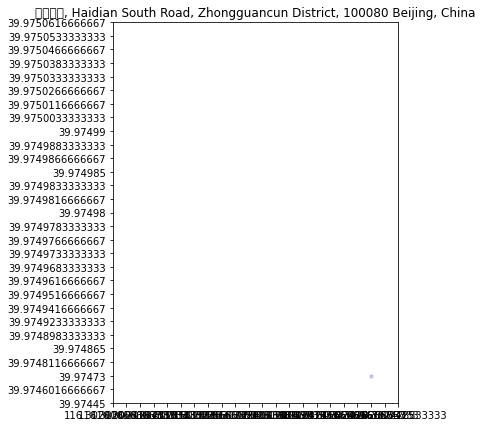

In [32]:

nframe=frame.iloc[:200]

BBox = ((nframe.Longitude.min(),nframe.Longitude.max(),nframe.Latitude.min(),nframe.Latitude.max()))

print('BBox: {}'.format(BBox))

newwc = nframe['Latitude'].value_counts()
newwc = newwc.iloc[:25]
counts = nframe.apply(pd.value_counts)
ax = newwc.plot.bar(x='Latitude', y='val',fontsize=6, rot=60)
print(newwc)
neec = nframe.groupby(["Longitude", "Latitude"]).size()
print(neec)
ruh_m = plt.imread('map.png')

fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(nframe.Longitude, nframe.Latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('海淀南路, Haidian South Road, Zhongguancun District, 100080 Beijing, China')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')





def lat_long_dist(lat1,lon1,lat2,lon2):
    # function for calculating ground distance between two lat-long locations
    R = 6373.0 # approximate radius of earth in km. 
    lat1 = radians( float(lat1) )
    lon1 = radians( float(lon1) )
    lat2 = radians( float(lat2) )
    lon2 = radians( float(lon2) )
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = round(R * c, 6)
    return distance


def computeDistance(sequencedf):
    prevLat = prevLon = 0 # dummy initiation
    total_dist = 0
    for N in range(len(sequencedf)):
        lat = float(sequencedf.at[N,'Latitude'])
        lon = float(sequencedf.at[N,'Longitude'])
        if N == 0:
            sequencedf.at[N,'ll_dist'] = 0
        else:
            sequencedf.at[N,'ll_dist'] = lat_long_dist(lat,lon, prevLat,prevLon)
        total_dist += sequencedf.at[N,'ll_dist']
        sequencedf.at[N,'ll_dist_traveled'] = round(total_dist,6)
        prevLat = lat
        prevLon = lon
    return round(total_dist,6)

def getTimeOffsets(df, timestamp_col='Datetime'):
    timeOffsets = (df[timestamp_col] - df[timestamp_col].shift()).fillna(pd.Timedelta(seconds=0))
    print(timeOffsets)
    return timeOffsets.dt.total_seconds().astype(int)


# main function
def findSpeed(df, time_interval = 5):    
    computeDistance(df)
    df['offset'] = getTimeOffsets(df)
    df['dspan'] = df['tspan']  = df['cspeed'] = df['diff'] = None
    
    for N in range(len(df)):
        if N == 0: continue
        backi = N
        totOffset = df.at[N,'offset']
        while totOffset <= time_interval*60 :
            backi -= 1
            totOffset += df.at[backi,'offset']
            if backi == 0: break

        tspan = df.at[N,'Datetime'] - df.at[backi,'Datetime']
        df.at[N,'tspan'] = tspan.seconds
        distance = df.at[N,'ll_dist_traveled'] - df.at[backi,'ll_dist_traveled']
        df.at[N,'dspan'] = round(distance,3)
        if distance == 0:
            speed = df.at[N, 'cspeed'] = 0
        else:
            speed = round(distance / tspan.seconds * 3600,2)
            df.at[N, 'cspeed'] = speed
        speed_diff = round(df.at[N,'cspeed'] - speed, 2)
        df.at[N,'diff'] = speed_diff
    return df

# calling the function
nframe['Datetime'] = nframe['Date'] + ' '+nframe['Time']
nframe['Datetime']=pd.to_datetime(nframe["Datetime"])
frame['Datetime'] = frame['Date'] + ' '+frame['Time']
frame['Datetime']=pd.to_datetime(frame["Datetime"])
#Parsing a datetime
#frame['Datetimes'] = [parser.parse(frame['Datetime'][i]).timestamp() for i in range(len(frame)) ]
df1 = findSpeed(nframe, time_interval = 5)
df2 = findSpeed(frame, time_interval = 5)

print(df1)
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 18))
df1.plot(x="tspan", y=["ll_dist_traveled","cspeed"], color=['g','r'])
plt.grid(True,which="both",ls="--",c='gray') 
L=plt.legend()
L.get_texts()[0].set_text('Distance')
L.get_texts()[1].set_text('Speed')
plt.show()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



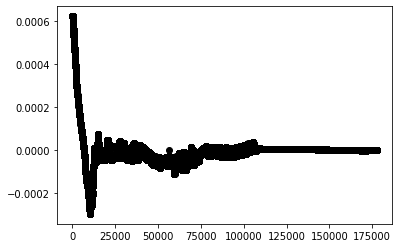

In [33]:
# run (your own) ACF
frame['Longitude']=pd.to_numeric(frame['Longitude'])
frame['Latitude']=pd.to_numeric(frame['Latitude'])
frame['latlon']=frame['Latitude']**2+frame['Longitude']**2
#latlon=np.array(frame['latlon'])
autocorr_coef = autocorrelation(frame['latlon'])
print(autocorr_coef)
import matplotlib.pyplot as plt

x = np.arange(0,len(autocorr_coef))
y = np.array(autocorr_coef)
plt.plot(x, y, 'o', color='black');

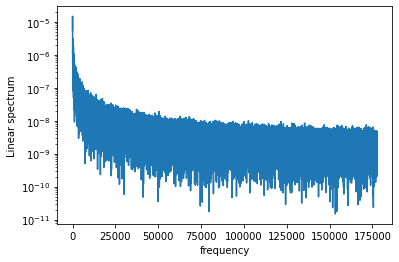

In [34]:
# run periodogram on the data
# work with periodogram, find a function available in one of the python packages
from scipy import signal
import matplotlib.pyplot as plt
f , Pxx_spec = signal.periodogram(autocorr_coef, len(autocorr_coef)*2, 'flattop', scaling='spectrum')
plt.figure()
plt.semilogy(f, np.sqrt(Pxx_spec))
plt.xlabel('frequency')
plt.ylabel('Linear spectrum')
plt.show()

### Conclusion


Little report on findings (max 250 words):
The most visited latitude areas were 
39.974845    10
39.974908     9
39.974843     8
39.974900     8
39.974903     6
39.974920     5
39.974717     5
that were the spots that were found most in the folder 20.
The data were gathered from a Beijing,China. The row 83 display a map of the movement of the trajectory. The color is stronger when the move stops and with slight color is the quickest movements.

An analysis of the movement is also display on the row 83, that shows the distance with respect the speed of the trajectory. It shows how the distance was covered from the trajectory and how the speed increases.
The autocorrelation function does not shows that the most of the lags are close to zero for the whole dataset 20 and only a small number of lag are out near to 0.6 and has negative value. From this plot can comment that the values that do not follow the pattern and do not concetrate near to zero are noise or outlier.

The periodogram display the general pattern of the signal tha is slowly decrease. The most dominant peaks are at the frequency 0-25000. The lowest value of the signal of the squared magnitude is in the frequency 150000.


## How do we grade this assignment?
Please pay attention to the following points. We consider these in calculating your final grade.

First of all, please check if you have pushed this notebook to the GitHub classroom before the deadline. You can check online on the GitHub classroom if the most up to date version of your code is present there, we can't grade your notebook if it is not there! **Make sure to read the *"Submission procedure"* section in the *"README.md"* file to ensure reproducibility.**

**1st part:**

1.   Your simulated data should have latitude and longitude.
2.   Your simulated data should have the correct dimensionality/frequency.
2.   It should also have both a daily and weekly cycle.



**2nd part:**


1. You should have correctly implemented the autocorrelation function.
2. We consider the graphs generated in grading.
3. We consider if the function returns 2 periodic cycles correctly.
4. We consider the extraction of the more prominent cycle. 



**3rd part:**

1.   We consider the implementation of the function based on periodogram.
2.   We consider if it works, it extracts 2 periods and identifies the most prominent one.



**4th part:**
1. We consider if two noise sources are added.
2. We check if both autocorrelation and periodogramd are applied to data.
3. We check if the results of the experiments are presented in a useful way.
4. We check the conclusions.


**5th part:**
1. We check if you have explored data.
2. We check if you have used periodogram and autocorrelation function.
3. We check your summary and reports. 